## Work at creating some interesting visuals for NYC transit with R

#### Load the required libraries

In [15]:
# repos=install.packages("RCurl", repos="https://cran.cnr.berkeley.edu/")
# repos=install.packages("RJSONIO", repos="https://cran.cnr.berkeley.edu/")
# repos=install.packages("plyr", repos="https://cran.cnr.berkeley.edu/")
# install.packages("RPostgreSQL", repos="https://cran.cnr.berkeley.edu/")
# install.packages("ggmap", repos="https://cran.cnr.berkeley.edu/")
# install.packages("chron", repos="https://cran.cnr.berkeley.edu/")

require("RPostgreSQL")
library(RCurl)
library(RJSONIO)
library(plyr)
library(ggplot2)
library(ggmap)
library(data.table)
library(chron)

#### See how geocode works

In [3]:
# Test 
FirstGeo = geocode("1200 Broadway,NY,NY")
# FirstGeo
length(names(FirstGeo))
# It works!
FirstGeo

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=1200%20Broadway,NY,NY&sensor=false


[1] 2

lon      lat
1 -73.98839 40.74617

#### Connect with our PostGreSQL database

In [13]:
# create a connection
# save the password that we can "hide" it as best as we can by collapsing it

myHost = Sys.getenv("W209_REDSHIFT_HOST")
myPort = Sys.getenv("W209_REDSHIFT_PORT")
myDB = Sys.getenv("W209_REDSHIFT_DB")
myUname = Sys.getenv("W209_REDSHIFT_UNAME")
myP <- { Sys.getenv("W209_REDSHIFT_PW") } # Turn off local echo


# loads the PostgreSQL driver
drv <- dbDriver("PostgreSQL")
# creates a connection to the postgres database
# note that "con" will be used later in each connection to the database
con <- dbConnect(drv, dbname = myDB,
                 host = myHost, port = myPort,
                 user = myUname, password = myP)
rm(myP) # removes the password
 
# check for the cartable
dbExistsTable(con, "for_hire_bases")
# TRUE

[1] TRUE

### Let's do an example taxi trip searches with sample user Pickup / Dropoff input
#### Replace Addr1 (pickup) and Addr2 (dropoff) with your own.

In [24]:
# Simulate user input
# Input a start and stop point
Addr1 = "357 Wall Street, NY, NY"
Addr2 = "1234 Atlantic Ave, NY, NY"
LongLat1 = geocode(Addr1)
LongLat2 = geocode(Addr2)
LongLat2

# Set start time for search
## FixThis:  manipulate start_time, stop_time to block the hour around the entered "ourTime"
ourTime = '2014-12-1 8:00:00'
start_time = '2014-12-1 8:00:00'
stop_time = '2015-12-30 9:00:00'

#Check distance
Dist = mapdist(from=Addr1, to=Addr2)

# Do Under / Over on distance 
Tol = 0.1
GeoTol = 0.0010
DistMin = Dist$m * (1-Tol)
DistMax = Dist$m * (1+Tol)
DistMax

# Do Under / Over on long and lat for pickup and drop-off
PULonRange = c(LongLat1$lon-GeoTol, LongLat1$lon+GeoTol)
PULatRange = c(LongLat1$lat-GeoTol, LongLat1$lat+GeoTol)
DOLonRange = c(LongLat2$lon-GeoTol, LongLat2$lon+GeoTol)
DOLatRange = c(LongLat2$lat-GeoTol, LongLat2$lat+GeoTol)


Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=357%20Wall%20Street,%20NY,%20NY&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=1234%20Atlantic%20Ave,%20NY,%20NY&sensor=false


lon     lat
1 -73.95194 40.6784

by using this function you are agreeing to the terms at :
http://code.google.com/apis/maps/documentation/distancematrix/

Information from URL : http://maps.googleapis.com/maps/api/distancematrix/json?origins=357+Wall+Street+NY+NY&destinations=1234+Atlantic+Ave+NY+NY&mode=driving&sensor=false


[1] 9981.4

### SQL query to locate all recorded taxi trips within +/- tol of both pickup and dropoff points above
### ...and between time_start and time_stop

In [25]:
sqlQuery <- paste("SELECT id, trip_distance, pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, 
dropoff_longitude, dropoff_latitude, total_amount  from trips WHERE (pickup_datetime BETWEEN '",start_time, "' AND '", stop_time, "') 
AND (pickup_longitude BETWEEN ", PULonRange[1]," AND ", PULonRange[2], ") AND (pickup_latitude BETWEEN ", PULatRange[1],
                  " AND ", PULatRange[2],") AND (dropoff_longitude BETWEEN ", DOLonRange[1]," AND ", DOLonRange[2],
                  ") AND (dropoff_latitude BETWEEN ", DOLatRange[1]," AND ", DOLatRange[2],");", sep = "")
df_trips <- dbGetQuery(con, sqlQuery)
# df_trips <- dbGetQuery(con, "SELECT id, trip_distance, pickup_datetime, dropoff_datetime, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, total_amount  from trips WHERE (pickup_datetime BETWEEN '2015-12-1 8:00:00' and '2015-12-1  9:00:00'")

In [26]:
names(df_trips)
df_trips <- data.table(df_trips)

[1] "id"                "trip_distance"     "pickup_datetime"  
[4] "dropoff_datetime"  "pickup_longitude"  "pickup_latitude"  
[7] "dropoff_longitude" "dropoff_latitude"  "total_amount"

In [27]:
df_trips <- na.omit(df_trips)
length(df_trips$id)

[1] 7

In [28]:
# Use mapply (multi-variate sapply) to Create for each row a pickup address and dropoff address (reverse geocode.)

{ df_trips[, pickup_address:=mapply(function(x,y) {
                                      # return(revgeocode(x))
                                      revgeocode(c(x,y))
                                      return(revgeocode(c(x,y)))
    }, x=pickup_longitude, y=pickup_latitude)
        ]
 }

{ df_trips[, dropoff_address:=mapply(function(x,y) {
                                      # return(revgeocode(x))
                                      return(revgeocode(c(x,y)))
    }, x=dropoff_longitude, y=dropoff_latitude)
        ]
 }

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.70576095581,-74.013198852539&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.70576095581,-74.013198852539&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.705791473388,-74.012832641601&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.705791473388,-74.012832641601&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.705001831054,-74.013023376464&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.705001831054,-74.013023376464&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.705909729003,-74.013351440429&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.705909729003,-74.013351440429&sensor=false
In

id trip_distance     pickup_datetime    dropoff_datetime
1: 103712772          5.98 2015-07-25 02:33:51 2015-07-25 02:50:40
2: 153634778          5.41 2015-12-04 00:14:53 2015-12-04 00:39:11
3:  53041793          5.66 2015-03-08 04:33:02 2015-03-08 04:54:16
4:  55782299          5.70 2015-03-18 22:45:57 2015-03-18 23:07:32
5:  85799122          5.97 2015-06-04 00:04:49 2015-06-04 00:32:56
6:  92231262          6.30 2015-06-25 23:13:17 2015-06-25 23:30:19
7: 139880199          5.90 2015-10-29 12:38:44 2015-10-29 13:09:29
   pickup_longitude pickup_latitude dropoff_longitude dropoff_latitude
1:        -74.01320        40.70576         -73.95223         40.67781
2:        -74.01283        40.70579         -73.95124         40.67843
3:        -74.01302        40.70500         -73.95188         40.67846
4:        -74.01335        40.70591         -73.95181         40.67791
5:        -74.01360        40.70558         -73.95181         40.67781
6:        -74.01320        40.70565         -73.95176         40.67843
7:        -74.01321        40.70565         -73.95155         40.67842
   total_amount                          pickup_address
1:        20.30    28 Broadway, New York, NY 10004, USA
2:        27.36    32 Broadway, New York, NY 10004, USA
3:        25.30 2-12 Beaver St, New York, NY 10004, USA
4:        27.30    2 Morris St, New York, NY 10004, USA
5:        28.80    27 Broadway, New York, NY 10004, USA
6:        27.65    28 Broadway, New York, NY 10004, USA
7:        31.00    28 Broadway, New York, NY 10004, USA

.Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.677810668945,-73.952232360839&sensor=false
.Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.678428649902,-73.95124053955&sensor=false
.Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.678462982177,-73.951881408691&sensor=false
.Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.677906036376,-73.951805114746&sensor=false
.Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.677814483642,-73.951805114746&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.678432464599,-73.951759338378&sensor=false
.Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.678421020507,-73.951553344726&sensor=false


id trip_distance     pickup_datetime    dropoff_datetime
1: 103712772          5.98 2015-07-25 02:33:51 2015-07-25 02:50:40
2: 153634778          5.41 2015-12-04 00:14:53 2015-12-04 00:39:11
3:  53041793          5.66 2015-03-08 04:33:02 2015-03-08 04:54:16
4:  55782299          5.70 2015-03-18 22:45:57 2015-03-18 23:07:32
5:  85799122          5.97 2015-06-04 00:04:49 2015-06-04 00:32:56
6:  92231262          6.30 2015-06-25 23:13:17 2015-06-25 23:30:19
7: 139880199          5.90 2015-10-29 12:38:44 2015-10-29 13:09:29
   pickup_longitude pickup_latitude dropoff_longitude dropoff_latitude
1:        -74.01320        40.70576         -73.95223         40.67781
2:        -74.01283        40.70579         -73.95124         40.67843
3:        -74.01302        40.70500         -73.95188         40.67846
4:        -74.01335        40.70591         -73.95181         40.67791
5:        -74.01360        40.70558         -73.95181         40.67781
6:        -74.01320        40.70565         -73.95176         40.67843
7:        -74.01321        40.70565         -73.95155         40.67842
   total_amount                          pickup_address
1:        20.30    28 Broadway, New York, NY 10004, USA
2:        27.36    32 Broadway, New York, NY 10004, USA
3:        25.30 2-12 Beaver St, New York, NY 10004, USA
4:        27.30    2 Morris St, New York, NY 10004, USA
5:        28.80    27 Broadway, New York, NY 10004, USA
6:        27.65    28 Broadway, New York, NY 10004, USA
7:        31.00    28 Broadway, New York, NY 10004, USA
                              dropoff_address
1:   1223 Pacific St, Brooklyn, NY 11216, USA
2: 1238 Atlantic Ave, Brooklyn, NY 11216, USA
3: 1234 Atlantic Ave, Brooklyn, NY 11216, USA
4:   1229 Pacific St, Brooklyn, NY 11216, USA
5:   1229 Pacific St, Brooklyn, NY 11216, USA
6: 1234 Atlantic Ave, Brooklyn, NY 11216, USA
7: 1238 Atlantic Ave, Brooklyn, NY 11216, USA

In [29]:
# Use the first trip in our query return starting point as the centre point of the map
start_long = df_trips[1,pickup_longitude]
start_lat = df_trips[1,pickup_latitude]

# Create a route for all of the trip rows we've extracted so far.
## Much as I regret it, I was driven to use a loop as mapply returned individual routes as columns and I didn't find
## an obvious way to get the concatenated output in the format I wanted.

# Initialize the legs route
df_leg = data.frame()

NumRows = dim(df_trips)[1]
# NumRows = 1

for (i in (1:NumRows)) { 
    Foghorn_Leghorn = route(from=df_trips$pickup_address[i], to=df_trips$dropoff_address[i], alternatives=FALSE)
    df_leg <- rbind(df_leg, Foghorn_Leghorn)
}

# df_legnormal = route(from=df_trips$pickup_address[1], to=df_trips$dropoff_address[1], alternatives=FALSE)

# ?route
# names(df_leg)
# df_leg
# df_leg

Information from URL : http://maps.googleapis.com/maps/api/directions/json?origin=28+Broadway,+New+York,+NY+10004,+USA&destination=1223+Pacific+St,+Brooklyn,+NY+11216,+USA&mode=driving&units=metric&alternatives=false&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/directions/json?origin=32+Broadway,+New+York,+NY+10004,+USA&destination=1238+Atlantic+Ave,+Brooklyn,+NY+11216,+USA&mode=driving&units=metric&alternatives=false&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/directions/json?origin=2-12+Beaver+St,+New+York,+NY+10004,+USA&destination=1234+Atlantic+Ave,+Brooklyn,+NY+11216,+USA&mode=driving&units=metric&alternatives=false&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/directions/json?origin=2+Morris+St,+New+York,+NY+10004,+USA&destination=1229+Pacific+St,+Brooklyn,+NY+11216,+USA&mode=driving&units=metric&alternatives=false&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/directions/jso

Information from URL : http://maps.googleapis.com/maps/api/geocode/json?latlng=40.70576095581,-74.013198852539&sensor=false
Map from URL : http://maps.googleapis.com/maps/api/staticmap?center=28+Broadway,+New+York,+NY+10004,+USA&zoom=12&size=640x640&scale=2&maptype=hybrid&language=en-EN&sensor=false
Information from URL : http://maps.googleapis.com/maps/api/geocode/json?address=28%20Broadway,%20New%20York,%20NY%2010004,%20USA&sensor=false


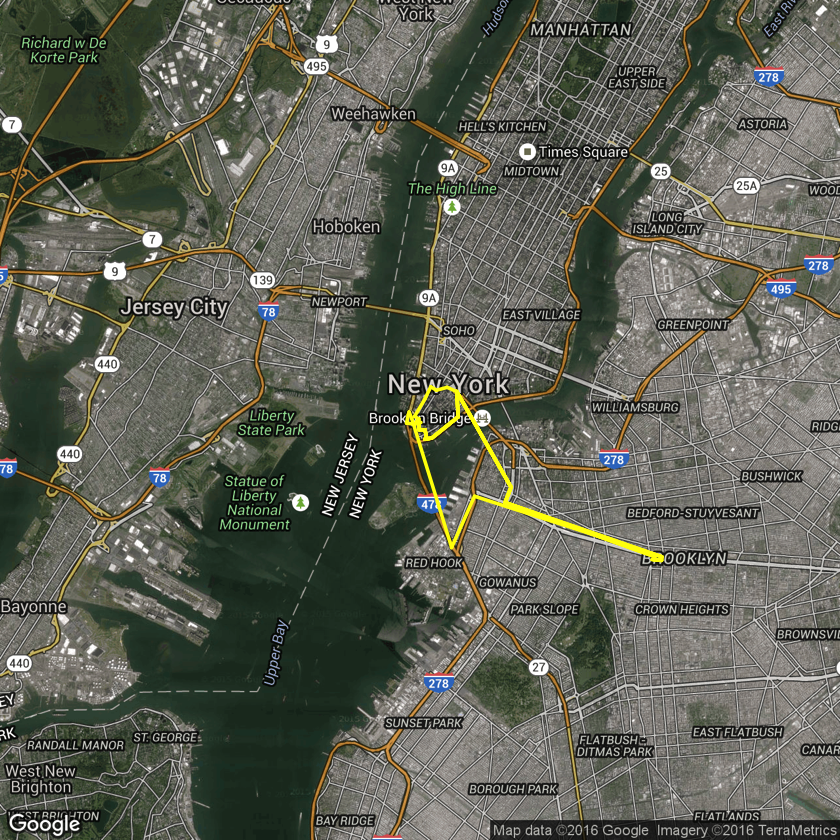

In [30]:
# Now it's time to play around with geographic information systems!
#map <- get_map(
#   location = geocode('123 Wall Street NY, NY'), 
#     source = "google", zoom = 13
# )
# ggmap(map)

# ggplot(data = legs_df) +
# inset_ggmap(map) +
# geom_leg( aes(x = startLon, y = startLat, xend = endLon, yend = endLat, color=route), data=legs_df) + coord_map()
         

qmap(revgeocode(c(start_long,start_lat)), zoom = 12, maptype='hybrid',  
base_layer = ggplot(aes(x = startLon, y = startLat), data = df_leg)) +
geom_leg(aes(x = startLon, y = startLat, xend = endLon, yend = endLat), colour='Yellow', alpha =1, size = 1, data = df_leg) +
labs(x = 'Longitude', y = 'Latitude', colour = 'Route')
# facet_wrap(~ route, ncol = 3) + theme(legend.position = 'top')